In [1]:
# comment it when editing
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import packages
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,9)
# %matplotlib notebook
# from ipywidgets import *
from numpy import *
import datetime
# connecting matlab api
# import matlab.engine
# eng = matlab.engine.start_matlab()
from scipy.stats import *
from scipy.optimize import minimize
from statsmodels.tsa.ar_model import *

In [3]:
# Processing on futures price data
fp = pd.read_table("d_sp500f_1987.txt",index_col=0,delimiter=" ")
fp["TradeDate"] = fp["TradeDate"].apply(lambda x:pd.to_datetime(str(x)))
fp.columns = ['Trade_Date', 'DeliveryMonth', 'SettlePrice']

In [4]:
fp.head()

,Trade_Date,DeliveryMonth,SettlePrice
TradeSeq,,,
1,1987-01-02,8703,246.75
2,1987-01-05,8703,253.25
3,1987-01-06,8703,253.55
4,1987-01-07,8703,256.25
5,1987-01-08,8703,257.30


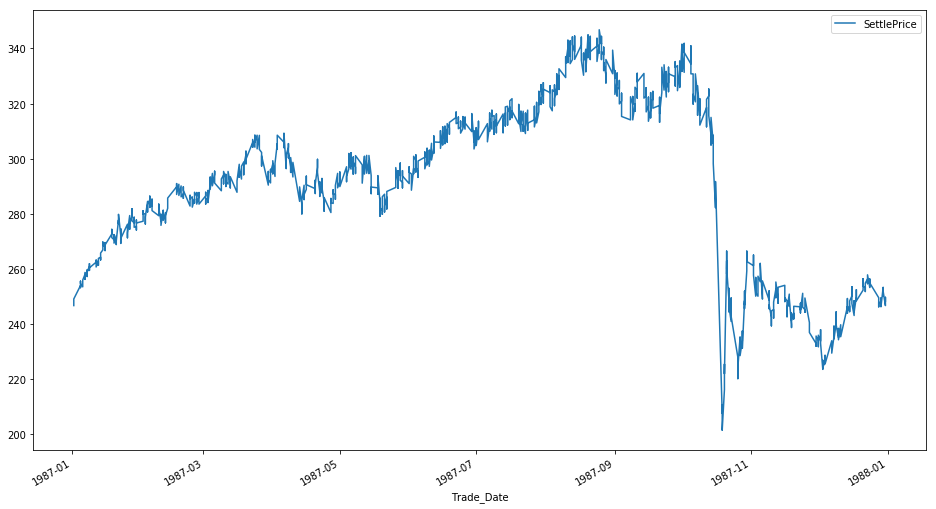

In [5]:
fp.plot('Trade_Date','SettlePrice')

In [6]:
def fp_extraction(future_delivery_month,df=fp,window=60):
    df = df.loc[fp['DeliveryMonth']==future_delivery_month]
    df["Return"] = df["SettlePrice"].shift(1)/df["SettlePrice"]
    df["LogReturn"] = log(df["Return"])
    df["HistDailyVol"] = df["LogReturn"].rolling(window=window).std()
    df["HistAnnualVol"] = df["HistDailyVol"]* sqrt(252)
    # df = df.loc[df["HistAnnualVol"].isnull() == False]
    return df[['Trade_Date','DeliveryMonth','SettlePrice','HistAnnualVol']]

In [7]:
fp_8803 = fp_extraction(8803)
fp_8709 = fp_extraction(8709)

In [8]:
# Processing on Interest rate data
tbill3m = pd.read_table("m_tbill_3m.txt",delimiter="   ",error_bad_lines=False,engine='python')
tbill3m["DATE"] = pd.to_datetime(tbill3m["DATE"])
tbill3m = fp.groupby('Trade_Date',as_index=False).mean().merge(tbill3m,how='left',left_on='Trade_Date',right_on='DATE')[['Trade_Date','VALUE']]
tbill3m["VALUE"] = tbill3m["VALUE"].fillna(method ='ffill')
tbill3m["AnnualRate"] = tbill3m["VALUE"] / 100 
tbill3m = tbill3m[['Trade_Date','AnnualRate']]

Skipping line 13: Expected 2 fields in line 13, saw 3. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 33: Expected 2 fields in line 33, saw 3. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 77: Expected 2 fields in line 77, saw 3. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 103: Expected 2 fields in line 103, saw 3. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 132: Expected 2 fields in line 132, saw 3. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 178: Expected 2 fields in line 178, saw 3. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 203: Expected 2 fields in line 203, saw 3. Error could possibly be due to quotes being ignored when a multi-char del

In [9]:
# Processing on Option pricing data
fopt = pd.read_table("d_sp500fopt_1987.txt", index_col=0, delimiter="\t")
fopt["Trade_Date"] = fopt["Trade_Date"].apply(lambda x:pd.to_datetime(str(x)))
fopt["Years_to_Exp"] = fopt["Days_to_Exp"]/365
fopt=fopt.drop("Unnamed: 6",axis=1)
fopt.columns = ['Trade_Date', 'Delivery_Month', 'Days_to_Exp', 'Strike_Price','OptionPrice', 'Type', 'Years_to_Exp']

In [10]:
fopt.head()

,Trade_Date,Delivery_Month,Days_to_Exp,Strike_Price,OptionPrice,Type,Years_to_Exp
Trade_Seq,,,,,,,
219,1987-11-11,8801,44,265,9.50,C,0.120548
220,1987-11-12,8801,43,265,11.75,C,0.117808
221,1987-11-13,8801,42,265,9.50,C,0.115068
222,1987-11-16,8801,41,265,8.00,C,0.112329
223,1987-11-17,8801,40,265,6.50,C,0.109589


In [11]:
#  Options to be priced
fopt_8803c =fopt.loc[(fopt["Delivery_Month"]==8803)&(fopt["Strike_Price"]==330)&(fopt["Type"]=="C")]
fopt_8803p =fopt.loc[(fopt["Delivery_Month"]==8803)&(fopt["Strike_Price"]==290)&(fopt["Type"]=="P")]

In [12]:
# Options for training
fopt_8709c =fopt.loc[(fopt["Delivery_Month"]==8709)&\
                     (fopt["Strike_Price"]==260)&\
                     (fopt["Type"]=="C")&\
                     (fopt["Trade_Date"]<"1987-07-01")]
fopt_8709p =fopt.loc[(fopt["Delivery_Month"]==8709)&\
                     (fopt["Strike_Price"]==240)&\
                     (fopt["Type"]=="P")&\
                     (fopt["Trade_Date"]<"1987-07-01")]

In [13]:
def euro_vanilla(S, K, T, r, sigma, option = 'C'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    
    if option == 'C':
        result = (S * norm.cdf(d1, 0.0, 1.0) - K * exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
    if option == 'P':
        result = (K * exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
        
    return result

#euro_vanilla(260, 100, 1, 0.05, 0.25, option = 'P')

In [14]:
def calibrated_vol(time='1987-01-02',opt_type ="C"):
    # option data on a specific date
    df1 = fopt.loc[(fopt['Trade_Date'] == time)&(fopt['Type']==opt_type)]
    # furtue data on a specific date
    df2 = fp.loc[(fp['Trade_Date'] == time)]
    # merge data
    df3 = df1.merge(df2,how="left",left_on="Delivery_Month",right_on="DeliveryMonth")
    # get annual rate from tbill3m
    ann_rate = float(tbill3m.loc[tbill3m['Trade_Date']==time,'AnnualRate'])
    # function for BS pricing
    bsprice = lambda sigma: df3.apply(lambda x: euro_vanilla(x.SettlePrice,\
                            x.Strike_Price,x.Years_to_Exp,ann_rate,\
                            sigma,option = opt_type),axis=1)
    y = df3['OptionPrice']
    # error func
    error = lambda sigma, y: ((bsprice(sigma[0])-y)**2).sum()
    # fitting the data with minimize
    sigma= array([0.15])
    p = minimize(error, sigma, args=(y),bounds=[(0.05,2)])
    return p.x[0]

In [15]:
# This cell will take about 2 min to run, just read csv in the below cell
# date_list = [i for i in tbill3m['Trade_Date']]
# call_cvol_list = []
# put_cvol_list = []
# for i,x in enumerate(date_list):
#     call_cvol_list.append(calibrated_vol(time=date_list[i],opt_type='C'))
#     put_cvol_list.append(calibrated_vol(time=date_list[i],opt_type='P'))
#     print(x)
# cvol = pd.DataFrame({'TradeDate':date_list,
#                     'call_cvol':call_cvol_list,
#                     'put_cvol':put_cvol_list})
# cvol['Trade_Date'] = pd.to_datetime(cvol['Trade_Date'])
# cvol.to_csv('cvol.csv',index=False)

In [16]:
cvol = pd.read_csv('cvol.csv',parse_dates=True)
cvol['TradeDate'] = pd.to_datetime(cvol['TradeDate'])
cvol.columns = ['Trade_Date', 'call_cvol', 'put_cvol']

In [17]:
cvol.head()

,Trade_Date,call_cvol,put_cvol
0,1987-01-02,0.150957,0.220475
1,1987-01-05,0.144431,0.217607
2,1987-01-06,0.143401,0.217401
3,1987-01-07,0.140587,0.215474
4,1987-01-08,0.139587,0.215060


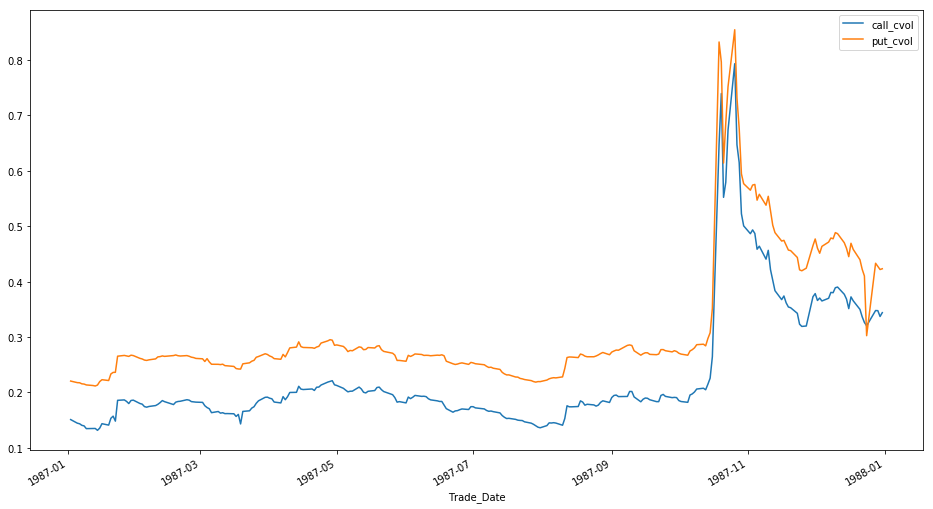

In [18]:
cvol.plot(x='Trade_Date',y=['call_cvol','put_cvol'])

In [19]:
# calculation for BS price
def calculation(df,opt_type,underlying_df):    
    # merge with interest data
    df = df.merge(tbill3m,how="left",on="Trade_Date")
    # merge with cvol
    df = df.merge(cvol,how="left",on="Trade_Date")
    # merge with historical std data
    df =  df.merge(underlying_df,how="left",on="Trade_Date")
    df['BS_Price'] = df.apply(lambda x:euro_vanilla(x.SettlePrice,\
                        x.Strike_Price,x.Years_to_Exp,x.AnnualRate,\
                        x.HistAnnualVol,x.Type),axis=1)
    
    # calibrated price
    df['BSC_Price'] = df.apply(lambda x: euro_vanilla(x.SettlePrice,\
                    x.Strike_Price,x.Years_to_Exp,x.AnnualRate,\
                    x.call_cvol,x.Type) if opt_type=='C' else
                               euro_vanilla(x.SettlePrice,\
                    x.Strike_Price,x.Years_to_Exp,x.AnnualRate,\
                    x.put_cvol,x.Type),axis=1)
    
    return df

In [20]:
fopt_8803c_calc = calculation(fopt_8803c,"C",underlying_df=fp_8803)
fopt_8803p_calc = calculation(fopt_8803p,"P",underlying_df=fp_8803)

In [21]:
fopt_8709c_calc = calculation(fopt_8709c,"C",underlying_df=fp_8709)
fopt_8709p_calc = calculation(fopt_8709p,"P",underlying_df=fp_8709)

In [22]:
def train(df):
#input: output of func:calculation
    df['Error'] = df['OptionPrice']-df['BSC_Price']
    train = df[['Trade_Date','Error']]
    train.plot('Trade_Date','Error')
    model = AR(asarray(train['Error'])).fit(method='mle', ic='aic', trend='c')
    alpha, beta = model.params
    plt.show()
    return alpha, beta, train

In [23]:
oose = lambda df: sqrt(((df['OptionPrice']-df['EstimatedPrice'])**2).sum()/df.shape[0])
def test(df,alpha,beta,option):
# input: output from calculation(df of period you want to test)
    if option == 'C':
        cvol= 'call_cvol'
    elif option =='P':
        cvol= 'put_cvol'
    else:
        raise ValueError('Call(C) or Put(P)?')

    test = df[['Trade_Date','OptionPrice',cvol,'BSC_Price']]
    test['Diff'] = test['OptionPrice']-test['BSC_Price']
    test['EstimatedPrice'] = test['BSC_Price'] + alpha + beta*(test['Diff'].shift(1))
    out_of_sample_error = oose(test)
    test.plot('Trade_Date',['OptionPrice','EstimatedPrice'])
    print("Out of sample error: ",out_of_sample_error)
    plt.show()
    return out_of_sample_error,test

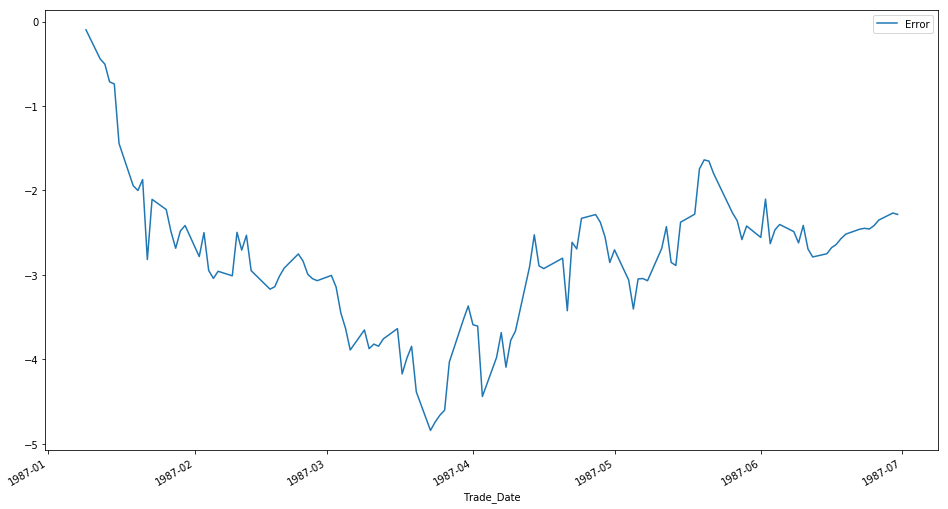

In [24]:
# testing for call option
alpha, beta, train_df = train(fopt_8709c_calc)

Out of sample error:  0.6030921048922615


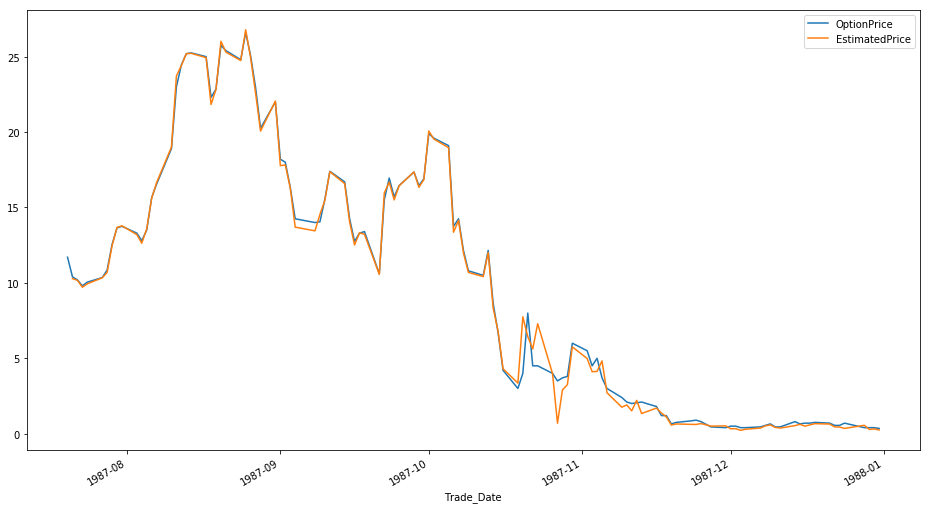

In [25]:
out_of_sample_error,test_df = test(fopt_8803c_calc,alpha,beta,'C')

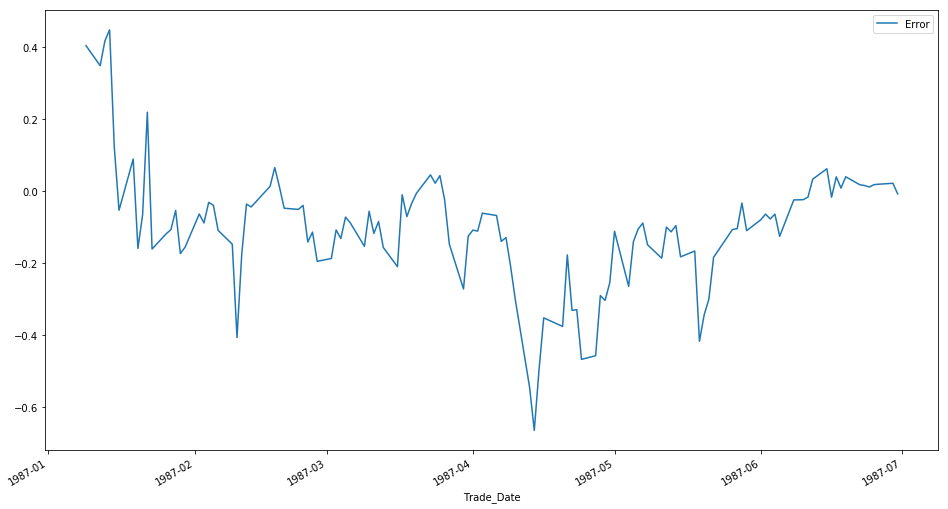

In [26]:
# testing for put option
alpha, beta, train_df = train(fopt_8709p_calc)

Out of sample error:  1.1020707679737043


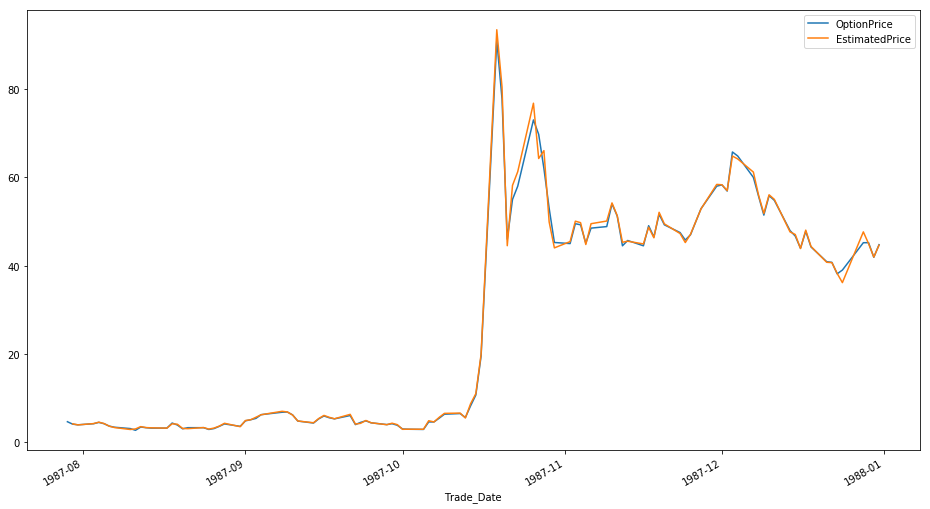

In [27]:
out_of_sample_error,test_df = test(fopt_8803p_calc,alpha,beta,'P')